In [5]:
"""
'Get rich quick' scheme, a 5-day prediction of FTSE/TWSE TW50 Index stock prices.

Caveats:

1. We used historical data from the beginning of 2020 (2020/01/02) to the 15th of March 2024
2. We will be predicting the price index
3. We write everything in Python
4. We compare several models and will only submit one result which we think is the best 

Hard requirements:

1. The dataset, which is a FTSE/TWSE TW-50 index stock from 2020-01-02 to 2024-03-15
"""

"\n'Get rich quick' scheme, a 5-day prediction of FTSE/TWSE TW50 Index stock prices.\n\nCaveats:\n\n1. We used historical data from the beginning of 2020 (2020/01/02) to the 15th of March 2024\n2. We will be predicting the price index\n3. We write everything in Python\n4. We compare several models and will only submit one result which we think is the best \n\nHard requirements:\n\n1. The dataset, which is a FTSE/TWSE TW-50 index stock from 2020-01-02 to 2024-03-15\n"

In [12]:
# ===== Imports =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import deque

(18263.0, 19797.0)

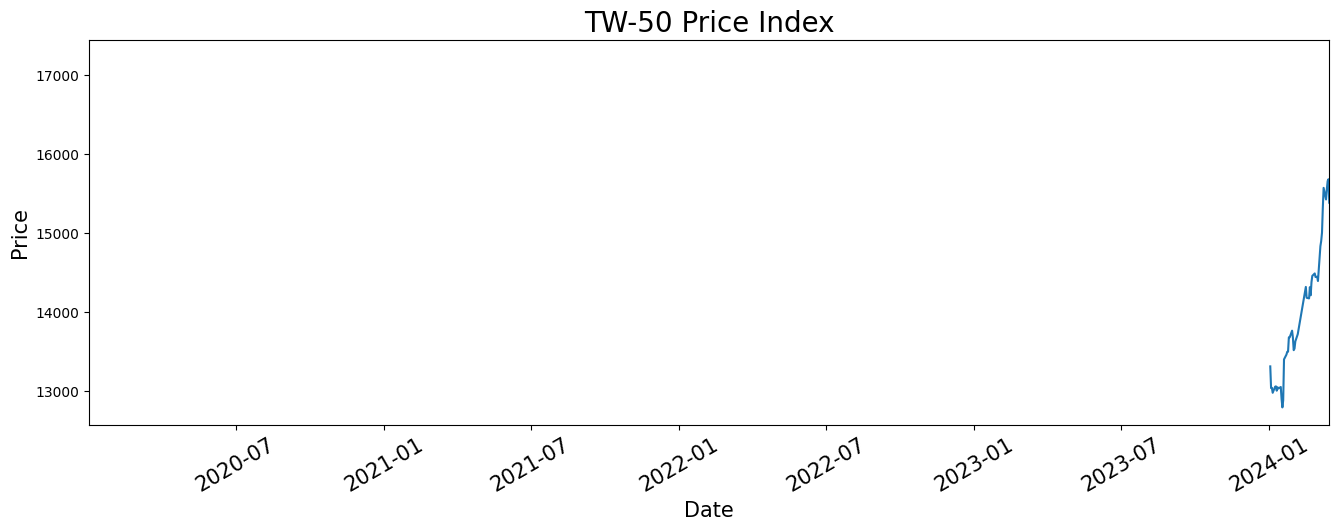

In [13]:
# ===== Data loading and plotting =====

dataset = pd.read_csv('dataset/Taiwan50Recent.csv')

# Since we will be predicting the price index, we will be making a dataframe with the values we'd like to predict
# I am lazy, so we just drop the unused columns instead
df = dataset.drop(columns=['Total Return Index', 'Change', '%Change'])
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True)

# Now, we just need to plot the dataset
fig = plt.subplots(figsize=(16, 5))
plt.plot(df['Date'], df['Price Index'])
plt.title('TW-50 Price Index', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2024-03-15'))

In [14]:
N_STEPS = 5
LOOKUP_STEPS = [1, 2, 3, 4, 5]
scaler = MinMaxScaler()

def prepare_data(_df: pd.DataFrame, days):
    ndf = _df.copy()
    ndf['Price Index'] = scaler.fit_transform(np.expand_dims(ndf['Price Index'].values, axis=1))

    ndf['Future'] = ndf['Price Index'].shift(-days)
    last_sequence = np.array(ndf[['Price Index']].tail(days))
    ndf.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(ndf[['Price Index'] + ['Date']].values, ndf['Future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['Price Index'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    x, y = [], []
    for seq, target in sequence_data:
        x.append(seq)
        y.append(target)

    # convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return ndf, last_sequence, x, y

In [15]:
# ===== Predicting stock prices using Transformers =====

# Using https://github.com/maym5/lstm_vs_transformer/blob/main/lstm_vs__transformer.ipynb for the transformer code

import tensorflow as tf
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [16]:
def get_trained_model(x_train, y_train):

    BATCH_SIZE = 8
    EPOCHS = 10

    transformer.compile(loss='mean_squared_error', optimizer='adam')

    transformer.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    return transformer

In [18]:
predictions = []
x_train, y_train, model = None, None, None

tf.keras.backend.clear_session()
for step in LOOKUP_STEPS:
    _df, last_sequence, x_train, y_train = prepare_data(df, step)
    x_train = x_train[:, :, :len(['Price Index'])].astype(np.float32)
    print(x_train.shape)

    model = get_trained_model(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

(87, 5, 1)
Epoch 1/10
11/11 [==============================] - 6s 338ms/step - loss: 0.0942
Epoch 2/10
11/11 [==============================] - 1s 49ms/step - loss: 0.0296
Epoch 3/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0140
Epoch 4/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 5/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0061
Epoch 6/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0042
Epoch 7/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0046
Epoch 8/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0046
Epoch 9/10
11/11 [==============================] - 0s 44ms/step - loss: 0.0045
Epoch 10/10
1/1 [==============================] - 2s 2s/step
(86, 5, 1)
Epoch 1/10
11/11 [==============================] - 5s 221ms/step - loss: 0.0093
Epoch 2/10
11/11 [==============================] - 1s 46ms/step - loss: 0.0065
Epoch 3/10
11/11 [================

In [19]:
print(predictions)

[17050.89, 17173.25, 17364.21, 17416.89, 17826.83]


In [22]:
# Execute model for the whole history range
predict_df = df.copy()
y_predicted = model.predict(x_train)
print(y_predicted.shape)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
print(y_predicted_transformed.shape)
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)


predict_df[f'Predicted Index'] = y_predicted_transformed

3/3 [==============================] - 0s 30ms/step
(83, 1)
(83,)


In [ ]:
import datetime as dt

# Add predicted results to the table
date_now = dt.date(year=2024, month=3, day=15+2)
date = [date_now + dt.timedelta(days=i) for i in range(0, N_STEPS)] 


for i, d in enumerate(date):
    predict_df.loc[len(predict_df)] = [pd.to_datetime(date[i]), predictions[i], 0]

In [ ]:
x = predict_df['Date'][-150:]
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(x.head(145), predict_df['Price Index'][-150:].head(145))
plt.plot(x.head(145), predict_df['Predicted Index'][-150:].head(145), linewidth=1, linestyle='dashed')
plt.plot(x.tail(6), predict_df['Price Index'][-150:].tail(6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend([f'Actual price',
            f'Predicted price',
            f'Predicted price for future 5 days'])
plt.show()